<a href="https://colab.research.google.com/github/DayrisRM/VisionArtificial-M1/blob/main/VGG_US_Datatset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving US_Original_dataset_final.zip to US_Original_dataset_final.zip


In [ ]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['US_Original_dataset_final.zip']), 'r')
data.extractall()

In [ ]:
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau


In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
model = define_model()
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_118 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_118 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 dropout_156 (Dropout)       (None, 112, 112, 32)      0         
                                                                 
 conv2d_119 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_119 (MaxPooli  (None, 56, 56, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_157 (Dropout)       (None, 56, 56, 64)      

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Cross Entropy Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])
  
  # save and show plot to file
  pyplot.savefig('metrics_plot.png')
  pyplot.show()
	


In [ ]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path, img_size=(224,224)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

IMG_SIZE = (224,224)
X_val, y_val, labels = load_data('US_Original_dataset_final/validation/', IMG_SIZE)
print(labels)

100%|██████████| 2/2 [00:00<00:00, 85.09it/s]

25 images loaded from US_Original_dataset_final/validation/ directory.
{0: 'Benign', 1: 'Malignant'}


In [ ]:
def validateOnValSet(model):
  predictions = model.predict(X_val)
  predictions = [1 if x>0.5 else 0 for x in predictions]
  accuracy = accuracy_score(y_val, predictions)
  print('')
  print('Val Accuracy on validation set = %.2f' % accuracy)
  confusion_mtx = confusion_matrix(y_val, predictions)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False) 


In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
  # define model
  model = define_model()
  # create data generator
  datagen = ImageDataGenerator(rescale=1.0/255.0)
  # prepare iterators
  train_it = datagen.flow_from_directory('US_Original_dataset_final/train/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
  test_it = datagen.flow_from_directory('US_Original_dataset_final/test/',
		class_mode='binary', batch_size=64, target_size=(224, 224))
  # callback
  #es = EarlyStopping(monitor='val_accuracy', patience=8, mode='max', verbose=1)
  es = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
  rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
  # fit model
  history = model.fit(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=40, verbose=1,
    callbacks=[es, rlrop])
  # evaluate model
  loss, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
  print('acc > %.3f' % (acc * 100.0))
  print("loss : ", loss)   
  # learning curves
  summarize_diagnostics(history)
  validateOnValSet(model)

Found 98 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


2/2 [==============================] - 13s 5s/step - loss: 1.3151 - accuracy: 0.4898 - val_loss: 1.3790 - val_accuracy: 0.3750 - lr: 0.0100
Epoch 2/40
2/2 [==============================] - 11s 5s/step - loss: 2.2382 - accuracy: 0.5102 - val_loss: 0.6848 - val_accuracy: 0.6500 - lr: 0.0100
Epoch 3/40
2/2 [==============================] - 11s 5s/step - loss: 0.6779 - accuracy: 0.7041 - val_loss: 0.6906 - val_accuracy: 0.4750 - lr: 0.0100
Epoch 4/40
2/2 [==============================] - 11s 5s/step - loss: 0.7258 - accuracy: 0.5102 - val_loss: 0.6815 - val_accuracy: 0.7000 - lr: 0.0100
Epoch 5/40
2/2 [==============================] - 11s 8s/step - loss: 0.6442 - accuracy: 0.7245 - val_loss: 0.6734 - val_accuracy: 0.6500 - lr: 0.0100
Epoch 6/40
2/2 [==============================] - 11s 8s/step - loss: 0.6301 - accuracy: 0.7041 - val_loss: 0.6565 - val_accuracy: 0.6500 - lr: 0.0100
Epoch 7/40
2/2 [==============================] - 11s 5s/step - loss: 0.6253 - accuracy: 0.6939 - val_los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.


1/1 [==============================] - 1s 1s/step - loss: 0.6058 - accuracy: 0.7250
> 72.500


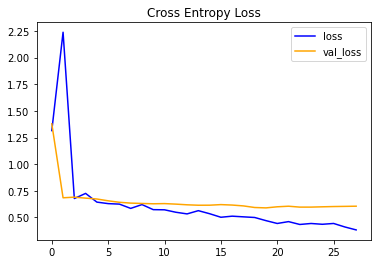

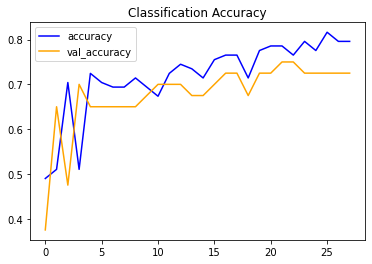


Val Accuracy on validation set = 0.72


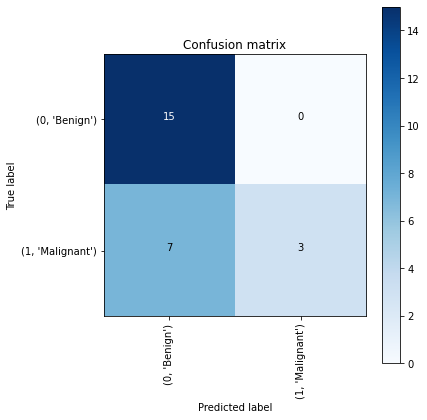

In [ ]:
# entry point, run the test harness
run_test_harness()